# Filtering signal in azimuthal space

Usually, diffraction signal presents a polar symmetry, this means all pixel with the same azimuthal angle (χ) have similar intensities. The best way to exploit this is to take the mean, what is called *azimuthal average*. But the average is very sensitive to outlier, like gaps, missing pixels, shadows, cosmic rays or reflection coming from larger crystallite. In this tutorial we will see two alternative ways to remove those unwanted signal and focus on the majority of pixels: **sigma clipping** and **median filtering**.

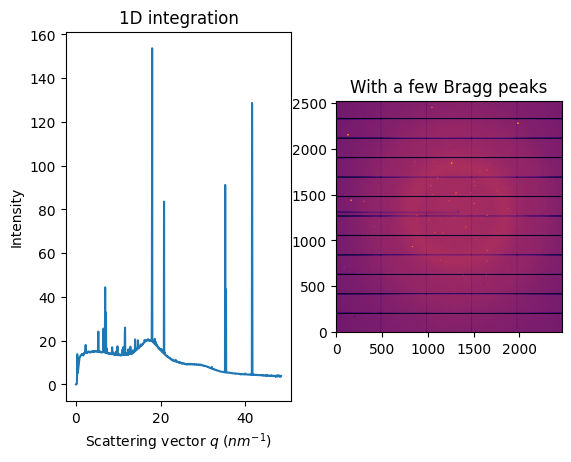

In [1]:
from matplotlib.pyplot import subplots
%matplotlib inline
from pyFAI.gui import jupyter
import numpy, fabio, pyFAI
from pyFAI import benchmark
from pyFAI.test.utilstest import UtilsTest

ai = pyFAI.load(UtilsTest.getimage("Pilatus6M.poni"))
img = fabio.open(UtilsTest.getimage("Pilatus6M.cbf")).data
fig, ax = subplots(1, 2)
jupyter.display(img, ax=ax[1])
jupyter.plot1d(ai.integrate1d(img, 1000), ax=ax[0])
ax[1].set_title("With a few Bragg peaks")
pass

## Azimuthal sigma-clipping

The idea is to discard pixels which look like outliers in the distribution of all pixels contributing to a single azimuthal bin.
It requires an error model like *poisson* but it has been proven to be better to use the variance in the given azimuthal ring.
All details are available in this publication: https://doi.org/10.1107/S1600576724011038 also available at https://doi.org/10.48550/arXiv.2411.09515 

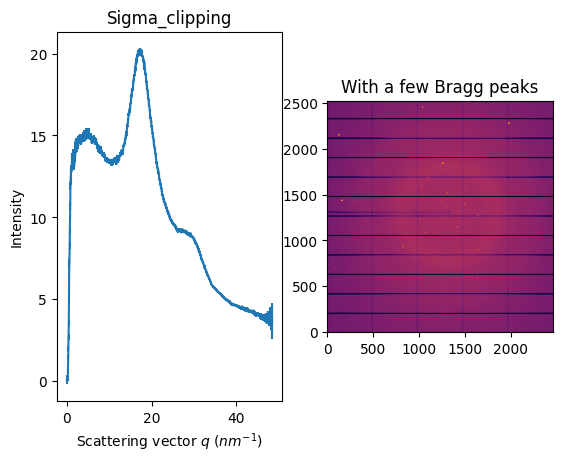

In [2]:
fig, ax = subplots(1, 2)
jupyter.display(img, ax=ax[1])
jupyter.plot1d(ai.sigma_clip(img, 1000, error_model="hybrid", method=("no", "csr", "cython")), ax=ax[0])
ax[1].set_title("With a few Bragg peaks")
ax[0].set_title("Sigma_clipping")
pass

Of course, *sigma-clip* takes several extra parameters like the number of iterations to perform, the cut-off, the error model, ... 
There are alo a few limitation: 
* The algorithm needs to be the CSR-sparse matrix multiplication: since several integration are needed, it makes no sense to use an histogram based algorithm.
* The algorithm is available with any implementation: Python (using scipy.saprse), Cython and OpenCL, and it runs just fine on GPU.
* Sigma-clipping is incompatible with any kind of pixel splitting: With pixel splitting, a single pixel can contribute to several azimuthal bins and discarding a pixel in one ring could disable it in the neighboring ring (or not, since bins are processed in parallel).

### Sigma-clipping performances:

In [3]:
method = ["no", "csr", "cython"]

In [4]:
%%time 
perfs_integrate_python = {}
perfs_integrate_cython = {}
perfs_integrate_opencl = {}
perfs_sigma_clip_python = {}
perfs_sigma_clip_cython = {}
perfs_sigma_clip_opencl = {}

for ds in pyFAI.benchmark.PONIS:
    ai = pyFAI.load(UtilsTest.getimage(ds))
    if ai.wavelength is None: ai.wavelength=1.54e-10
    img = fabio.open(UtilsTest.getimage(pyFAI.benchmark.datasets[ds])).data
    size = numpy.prod(ai.detector.shape)
    print(ds)
    print("     Cython")
    meth = tuple(method)
    nbin = max(ai.detector.shape)
    perfs_integrate_cython[size] = %timeit -o ai.integrate1d(img, nbin, method=meth)
    perfs_sigma_clip_cython[size] = %timeit -o ai.sigma_clip(img, nbin, method=meth, error_model="azimuthal")
    print("     Python")
    meth = tuple(method[:2]+["python"])
    perfs_integrate_python[size] = %timeit -o ai.integrate1d(img, nbin, method=meth)
    perfs_sigma_clip_python[size] = %timeit -o ai.sigma_clip(img, nbin, method=meth, error_model="azimuthal")

    print("     OpenCL")
    meth = tuple(method[:2]+["opencl"])
    perfs_integrate_opencl[size] = %timeit -o ai.integrate1d(img, nbin, method=meth)
    perfs_sigma_clip_opencl[size] = %timeit -o ai.sigma_clip(img, nbin, method=meth, error_model="azimuthal")

Pilatus1M.poni
     Cython
6.77 ms ± 97.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.19 ms ± 53.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
     Python
10.2 ms ± 25.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


153 ms ± 243 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
     OpenCL
865 µs ± 40.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.6 ms ± 3.76 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Pilatus2M.poni
     Cython
13.6 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
15.3 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
     Python
33.9 ms ± 60.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


520 ms ± 779 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
1.22 ms ± 69.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.01 ms ± 6.42 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Eiger4M.poni
     Cython
21.2 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
29.1 ms ± 381 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
     Python
61.3 ms ± 240 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


1.08 s ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
2.02 ms ± 34.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.5 ms ± 28 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Pilatus6M.poni
     Cython
29.9 ms ± 542 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
33.3 ms ± 373 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
     Python
84.7 ms ± 436 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


1.51 s ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
2.66 ms ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
13.4 ms ± 36 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Eiger9M.poni
     Cython
52.8 ms ± 560 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
67.2 ms ± 287 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
     Python
152 ms ± 386 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


2.82 s ± 3.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
3.97 ms ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
25 ms ± 21.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Mar3450.poni
     Cython
58 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
69.3 ms ± 205 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
     Python
168 ms ± 478 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


3.1 s ± 2.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
4.47 ms ± 30.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
27.5 ms ± 28.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Fairchild.poni
     Cython
87.5 ms ± 793 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
113 ms ± 585 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Compiler time: 0.25 s
     Python
385 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


8.89 s ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
4.36 ms ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
32.1 ms ± 69.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
CPU times: user 37min 21s, sys: 26.2 s, total: 37min 47s
Wall time: 5min 13s


Text(0.5, 1.0, 'Performance of Sigma-clipping vs integrate')

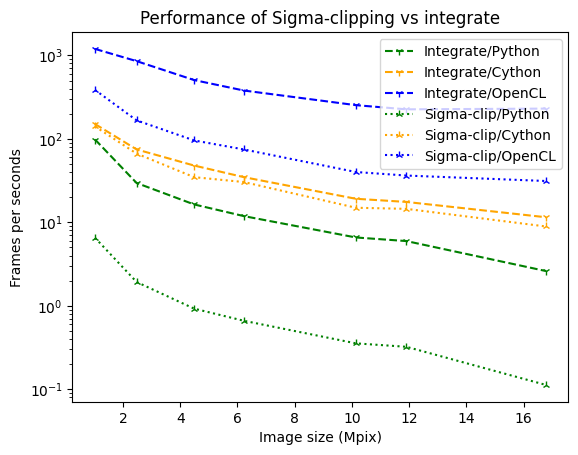

In [5]:
fig, ax = subplots()
ax.set_xlabel("Image size (Mpix)")
ax.set_ylabel("Frames per seconds")
sizes = numpy.array(list(perfs_integrate_python.keys()))/1e6
ax.plot(sizes, [1/i.best for i in perfs_integrate_python.values()], label="Integrate/Python", color='green', linestyle='dashed', marker='1')
ax.plot(sizes, [1/i.best for i in perfs_integrate_cython.values()], label="Integrate/Cython", color='orange', linestyle='dashed', marker='1')
ax.plot(sizes, [1/i.best for i in perfs_integrate_opencl.values()], label="Integrate/OpenCL", color='blue', linestyle='dashed', marker='1')
ax.plot(sizes, [1/i.best for i in perfs_sigma_clip_python.values()], label="Sigma-clip/Python", color='green', linestyle='dotted', marker='2')
ax.plot(sizes, [1/i.best for i in perfs_sigma_clip_cython.values()], label="Sigma-clip/Cython", color='orange', linestyle='dotted', marker='2')
ax.plot(sizes, [1/i.best for i in perfs_sigma_clip_opencl.values()], label="Sigma-clip/OpenCL", color='blue', linestyle='dotted', marker='2')
ax.set_yscale("log")
ax.legend()

ax.set_title("Performance of Sigma-clipping vs integrate")

The penalties is very limited in Cython, much more in Python.

The biggest limitation of sigma-clipping is its incompatibility with pixel-splitting, feature needed when oversampling, i.e. taking many more points than the size of the diagonal of the image.
While oversampling is not recommended in general case (due to the cross-corelation between bins it creates), it can be a nessessary evil, especially when performing Rietveld refinement where 5 points per peaks are needed, resolution that cannot be obtained with the pixel-size/distance couple accessible by the experimental setup.

## Median filter in Azimuthal space

The idea is to sort all pixels contibuting to an azimuthal bin and to average out all pixel between the lower and upper quantile. 
When those two thresholds are at one half, this filter provides actually the median.
In order to be compatible with pixel splitting, each pixel is duplicated as many times as it contributes to different bins.
After sorting fragments of pixels according to their normalization corrected signal, the cummulative sum of normalization is performed in order to detemine which fragments to average out.


In [6]:
ai = pyFAI.load(UtilsTest.getimage("Pilatus6M.poni"))
img = fabio.open(UtilsTest.getimage("Pilatus6M.cbf")).data

method = ["full", "csr", "cython"]
percentile=(40,60)
pol=0.99

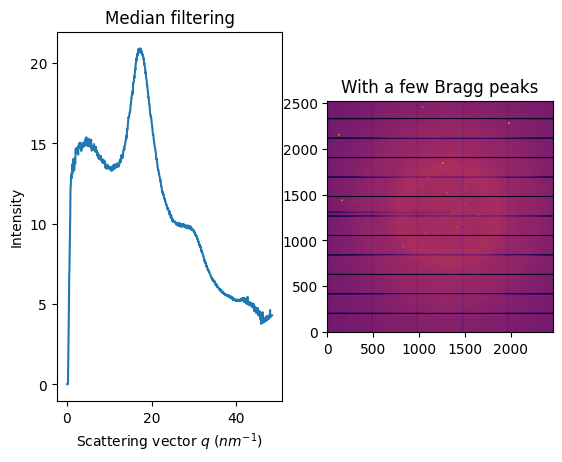

In [7]:
fig, ax = subplots(1, 2)
jupyter.display(img, ax=ax[1])
jupyter.plot1d(ai.medfilt1d_ng(img, 1000, method=method, percentile=percentile, polarization_factor=pol), ax=ax[0])
ax[1].set_title("With a few Bragg peaks")
ax[0].set_title("Median filtering")
pass

Unlike the *sigma-clipping*, this median filter does not equires any error model; but the computationnal cost induced by the sort is huge. In addition, the median is very sensitive and requires a good geometry and modelisation of the polarization.

In [8]:
%%time 
perf2_integrate_python = {}
perf2_integrate_cython = {}
perf2_integrate_opencl = {}
perf2_medfilt_python = {}
perf2_medfilt_cython = {}
perf2_medfilt_opencl = {}

for ds in pyFAI.benchmark.PONIS:
    ai = pyFAI.load(UtilsTest.getimage(ds))
    if ai.wavelength is None: ai.wavelength=1.54e-10
    img = fabio.open(UtilsTest.getimage(pyFAI.benchmark.datasets[ds])).data
    size = numpy.prod(ai.detector.shape)
    print(ds)
    print("     Cython")
    meth = tuple(method)
    nbin = max(ai.detector.shape)
    perf2_integrate_cython[size] = %timeit -o ai.integrate1d(img, nbin, method=meth)
    perf2_medfilt_cython[size] = %timeit -o ai.medfilt1d_ng(img, nbin, method=meth)
    print("     Python")
    meth = tuple(method[:2]+["python"])
    perf2_integrate_python[size] = %timeit -o ai.integrate1d(img, nbin, method=meth)
    perf2_medfilt_python[size] = %timeit -o ai.medfilt1d_ng(img, nbin, method=meth)

    print("     OpenCL")
    meth = tuple(method[:2]+["opencl"])
    perf2_integrate_opencl[size] = %timeit -o ai.integrate1d(img, nbin, method=meth)
    perf2_medfilt_opencl[size] = %timeit -o ai.medfilt1d_ng(img, nbin, method=meth)

Pilatus1M.poni
     Cython
6.67 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
24.2 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
     Python
12.7 ms ± 36.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


1.18 s ± 4.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
864 µs ± 506 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
9.94 ms ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Pilatus2M.poni
     Cython
13.5 ms ± 748 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
67.9 ms ± 782 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
     Python
46 ms ± 81.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


4.05 s ± 23.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
1.31 ms ± 467 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
32.9 ms ± 20.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Eiger4M.poni
     Cython
22.9 ms ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
116 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
     Python
82.9 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


7.04 s ± 33.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
2.15 ms ± 788 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
58.1 ms ± 20.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Pilatus6M.poni
     Cython
31.4 ms ± 784 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
155 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
     Python
113 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


10.3 s ± 69.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
2.89 ms ± 1.74 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
83 ms ± 76.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Eiger9M.poni
     Cython
48.9 ms ± 491 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
243 ms ± 3.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     Python
182 ms ± 694 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


17.4 s ± 160 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
4.37 ms ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
148 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Mar3450.poni
     Cython
54.5 ms ± 771 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
257 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     Python
227 ms ± 493 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


19.8 s ± 33.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
5.12 ms ± 21.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
174 ms ± 394 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Fairchild.poni
     Cython
86.3 ms ± 373 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
406 ms ± 6.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     Python
311 ms ± 830 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


24.4 s ± 94.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     OpenCL
4.76 ms ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
185 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
CPU times: user 22min 42s, sys: 26.1 s, total: 23min 8s
Wall time: 14min 10s


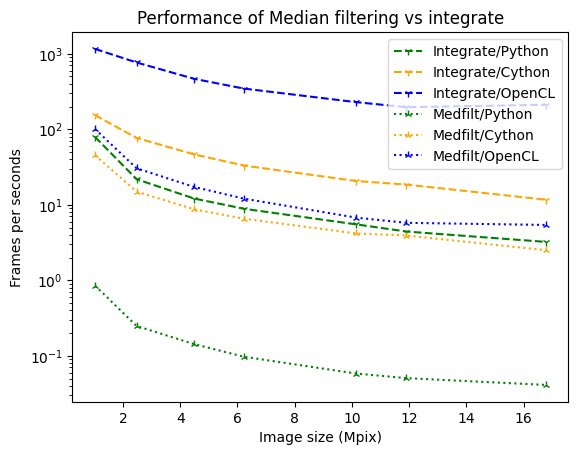

In [9]:
fig, ax = subplots()
ax.set_xlabel("Image size (Mpix)")
ax.set_ylabel("Frames per seconds")
sizes = numpy.array(list(perf2_integrate_python.keys()))/1e6
ax.plot(sizes, [1/i.best for i in perf2_integrate_python.values()], label="Integrate/Python", color='green', linestyle='dashed', marker='1')
ax.plot(sizes, [1/i.best for i in perf2_integrate_cython.values()], label="Integrate/Cython", color='orange', linestyle='dashed', marker='1')
ax.plot(sizes, [1/i.best for i in perf2_integrate_opencl.values()], label="Integrate/OpenCL", color='blue', linestyle='dashed', marker='1')
ax.plot(sizes, [1/i.best for i in perf2_medfilt_python.values()], label="Medfilt/Python", color='green', linestyle='dotted', marker='2')
ax.plot(sizes, [1/i.best for i in perf2_medfilt_cython.values()], label="Medfilt/Cython", color='orange', linestyle='dotted', marker='2')
ax.plot(sizes, [1/i.best for i in perf2_medfilt_opencl.values()], label="Medfilt/OpenCL", color='blue', linestyle='dotted', marker='2')
ax.set_yscale("log")
ax.legend()
ax.set_title("Performance of Median filtering vs integrate")
pass

As one can see, the penalities are much larger for OpenCL and Python than for Cython.

## Conclusion
*Sigma-clipping* and *median-filtering* are alternatives to azimuthal integration and offer the ability to reject outlier. They are mot more difficult to use but slightly slower owing to their greater complexity.